# 3 layer Conv Encoder, LSTM Decoder. 30 day input, 7 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [20]:
save_dir = 'models/lstm6'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [3]:
num_input = 30
num_out = 7
train_X, train_y, dev_X, dev_y, test_X, test_y, y = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)

train_X shape (638, 30, 25)
train_y shape (638, 7, 1)
dev_X shape (80, 30, 25)
dev_y shape (80, 7, 1)
test_X shape (80, 30, 25)
test_y shape (80, 7, 1)


In [12]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.3
epochs = 200
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, padding='same', kernel_size=3, activation='linear', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(RepeatVector(num_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

[autoreload of utils failed: Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 30, 64)            4864      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 64)            256       
_________________________________________________________________
activation_4 (Activation)    (None, 30, 64)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 64)            256       
_________________________________________________________________
activation_5 (Activation)    (None, 30, 64)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 64)            0         
__________

In [27]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.001
decay = 1e-6
dropout_rate = 0.3
epochs = 200
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, padding='same', kernel_size=3, activation='linear', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout_rate))

model.add(LSTM(200, activation='relu', input_shape=input_shape))
model.add(RepeatVector(num_out))

model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 30, 64)            4864      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 64)            256       
_________________________________________________________________
activation_7 (Activation)    (None, 30, 64)            0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               212000    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 7, 200)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 200)            320800    
__________

In [28]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 200 epochs, 32 batch size
Train on 638 samples, validate on 80 samples
Epoch 1/200
638/638 [==============================] - 4s 6ms/step - loss: 0.0334 - val_loss: 0.0036
Epoch 2/200
638/638 [==============================] - 2s 3ms/step - loss: 0.0071 - val_loss: 0.0044
Epoch 3/200
638/638 [==============================] - 2s 3ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 4/200
638/638 [==============================] - 2s 3ms/step - loss: 0.0043 - val_loss: 0.0031
Epoch 5/200
638/638 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 6/200
638/638 [==============================] - 2s 3ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/200
638/638 [==============================] - 2s 3ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 8/200
638/638 [==============================] - 2s 3ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 9/200
638/638 [==============================] - 2s 3ms/step - loss: 0.0027 - val_

638/638 [==============================] - 2s 2ms/step - loss: 4.4254e-04 - val_loss: 0.0032
Epoch 79/200
638/638 [==============================] - 2s 2ms/step - loss: 4.4317e-04 - val_loss: 0.0057
Epoch 80/200
638/638 [==============================] - 2s 2ms/step - loss: 4.3842e-04 - val_loss: 0.0037
Epoch 81/200
638/638 [==============================] - 2s 2ms/step - loss: 4.4234e-04 - val_loss: 0.0067
Epoch 82/200
638/638 [==============================] - 2s 2ms/step - loss: 4.5513e-04 - val_loss: 0.0037
Epoch 83/200
638/638 [==============================] - 2s 2ms/step - loss: 5.3946e-04 - val_loss: 0.0094
Epoch 84/200
638/638 [==============================] - 2s 2ms/step - loss: 5.3432e-04 - val_loss: 0.0054
Epoch 85/200
638/638 [==============================] - 2s 2ms/step - loss: 4.5449e-04 - val_loss: 0.0081
Epoch 86/200
638/638 [==============================] - 2s 2ms/step - loss: 4.6743e-04 - val_loss: 0.0062
Epoch 87/200
638/638 [==============================] - 2s 

Epoch 155/200
638/638 [==============================] - 2s 3ms/step - loss: 2.4054e-04 - val_loss: 0.0175
Epoch 156/200
638/638 [==============================] - 2s 3ms/step - loss: 2.3612e-04 - val_loss: 0.0101
Epoch 157/200
638/638 [==============================] - 2s 3ms/step - loss: 2.8347e-04 - val_loss: 0.0108
Epoch 158/200
638/638 [==============================] - 2s 3ms/step - loss: 2.5070e-04 - val_loss: 0.0179
Epoch 159/200
638/638 [==============================] - 2s 3ms/step - loss: 2.3878e-04 - val_loss: 0.0156
Epoch 160/200
638/638 [==============================] - 2s 2ms/step - loss: 2.5754e-04 - val_loss: 0.0155
Epoch 161/200
638/638 [==============================] - 2s 2ms/step - loss: 2.6154e-04 - val_loss: 0.0161
Epoch 162/200
638/638 [==============================] - 2s 3ms/step - loss: 2.5555e-04 - val_loss: 0.0156
Epoch 163/200
638/638 [==============================] - 2s 3ms/step - loss: 3.0856e-04 - val_loss: 0.0151
Epoch 164/200
638/638 [==============

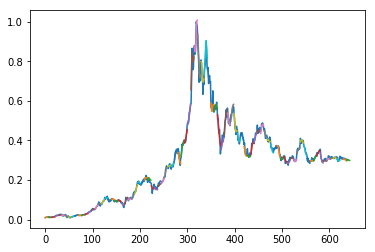

In [29]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_train.tolist(), true_train, num_out)

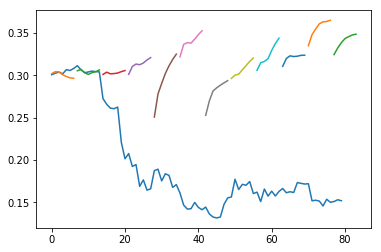

In [30]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_train = predicted_train.reshape(predicted_train.shape[0], -1)
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

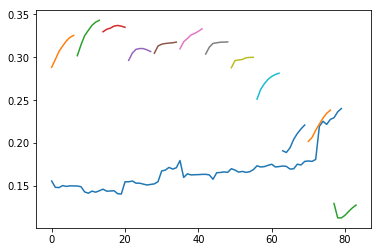

In [31]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [24]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.00028055936647118255
MSE Dev: 0.008687603025301003
MSE Test: 0.002287885160885926


In [32]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.6499215070643642
Acc Dev: 0.4430379746835443
Acc Test: 0.5063291139240507


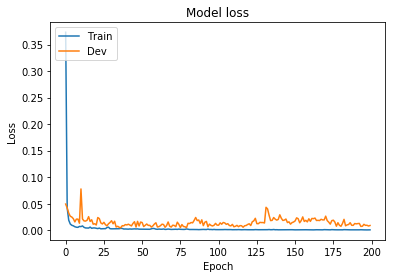

In [26]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()